In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [ ]:
# --- 1. HYPERPARAMETERS ---
SEED = 2345                 
BATCH_SIZE = 128             
LEARNING_RATE = 3e-5        
WEIGHT_DECAY = 5e-4         
NUM_EPOCHS = 10

pl.seed_everything(SEED, workers=True)

DATA_DIR = '../data/cropped'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
VAL_DIR = os.path.join(DATA_DIR, 'validation')


CHECKPOINT_DIR = '../data/cropped/checkpoints_cropped'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoint directory: {CHECKPOINT_DIR}")

RESUME_PATH = None


Seed set to 2345


Checkpoint directory: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/checkpoints_cropped


In [3]:

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, data_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, data_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, data_transforms)

# Classes found
print(f"Classes found: {train_dataset.classes}")

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data Loaded Successfully!")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Testing images: {len(test_dataset)}")

    

Classes found: ['fake', 'real']
Data Loaded Successfully!
Training images: 33550
Validation images: 7195
Testing images: 7187


In [ ]:
## Removing empty and corrupted files
from PIL import Image
folders = [
    os.path.join(DATA_DIR, 'train', 'real'),
    os.path.join(DATA_DIR, 'train', 'fake'),
    os.path.join(DATA_DIR, 'test', 'real'),
    os.path.join(DATA_DIR, 'test', 'fake'),
    os.path.join(DATA_DIR, 'validation', 'real'),
    os.path.join(DATA_DIR, 'validation', 'fake'),
]

corrupted_count = 0
empty_count = 0

for folder in folders:
    if not os.path.exists(folder):
        print(f"Warning: Folder does not exist: {folder}")
        continue
    
    print(f"\nScanning folder: {folder}")
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        
        if not os.path.isfile(path):
            continue
            
        if not f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            continue
      
        if os.path.getsize(path) == 0:
            os.remove(path)
            empty_count += 1
            print(f"  Deleted empty file: {f}")
            continue
        try:
            with Image.open(path) as img:
                img.verify()  
            img = Image.open(path)
            img.convert('RGB')  
            img.close()
            
        except Exception as e:
            # Image is corrupted - delete it
            os.remove(path)
            corrupted_count += 1
            print(f"  Deleted corrupted file: {f} - Error: {str(e)[:50]}")

print(f"\n=== Summary ===")
print(f"Deleted {empty_count} empty files")
print(f"Deleted {corrupted_count} corrupted files")
print(f"Total removed: {empty_count + corrupted_count}")



Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/train/real

Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/train/fake

Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/test/real

Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/test/fake

Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/validation/real

Scanning folder: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/validation/fake

=== Summary ===
Deleted 0 empty files
Deleted 0 corrupted files
Total removed: 0


In [ ]:
def get_efficientnet(use_gap=True):
    
    model = models.efficientnet_b0(weights='DEFAULT')
    
    for param in model.features.parameters():
        param.requires_grad = True
        
    in_features = model.classifier[1].in_features
    
    # The Experiment: Modify the Architecture
    if use_gap:
        # ROBUST MODE: Keep the default .avgpool (which is GAP)
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, 2)
        )
        print("Built Model with GAP")
        
    else:
        # FRAGILE MODE: Destroy GAP, force Flatten
        model.avgpool = nn.Identity() # Remove pooling
        
        flattened_size = 1280 * 7 * 7 
        
        model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 2)
        )
        print(" Built Model with Flatten")
        
    return model.to(device)

# Create the two variables
model_gap = get_efficientnet(use_gap=True)
model_flatten = get_efficientnet(use_gap=False)

Built Model with GAP
 Built Model with Flatten


In [ ]:
# CHECKPOINTS
import glob

def save_checkpoint(model, optimizer, epoch, history, model_name, checkpoint_dir):
    """Save complete checkpoint: model + optimizer + epoch + history"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'model_name': model_name
    }
    
    # Save epoch checkpoint
    filename = f"{model_name.replace(' ', '_')}_epoch_{epoch}.pth"
    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(checkpoint, filepath)
    print(f"Saved: {filename}")
    
    # Save best model (if current is best)
    if history['val_acc'] and len(history['val_acc']) > 0:
        current_val_acc = history['val_acc'][-1]
        best_val_acc = max(history['val_acc'])
        if current_val_acc >= best_val_acc:
            best_filepath = os.path.join(checkpoint_dir, f"{model_name.replace(' ', '_')}_best.pth")
            torch.save(checkpoint, best_filepath)
    
    # Save latest checkpoint
    latest_filepath = os.path.join(checkpoint_dir, f"{model_name.replace(' ', '_')}_latest.pth")
    torch.save(checkpoint, latest_filepath)

def load_checkpoint(checkpoint_path, model, optimizer, device):
    """Load checkpoint and return epoch and history"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']
    
    print(f"Loaded checkpoint from epoch {epoch}")
    return epoch, history

def find_latest_checkpoint(checkpoint_dir, model_name):
    """Find the latest checkpoint automatically"""
    pattern = os.path.join(checkpoint_dir, f"{model_name.replace(' ', '_')}_epoch_*.pth")
    checkpoints = glob.glob(pattern)
    
    if not checkpoints:
        return None
  
    def get_epoch(path):
        try:
            return int(os.path.basename(path).split('_epoch_')[1].split('.pth')[0])
        except:
            return -1
    
    latest = max(checkpoints, key=get_epoch)
    return latest

def list_checkpoints(checkpoint_dir, model_name):
    """List all available checkpoints for a model"""
    pattern = os.path.join(checkpoint_dir, f"{model_name.replace(' ', '_')}_epoch_*.pth")
    checkpoints = sorted(glob.glob(pattern), key=lambda x: int(os.path.basename(x).split('_epoch_')[1].split('.pth')[0]))
    
    if checkpoints:
        print(f"Available checkpoints for '{model_name}':")
        for cp in checkpoints:
            epoch = os.path.basename(cp).split('_epoch_')[1].split('.pth')[0]
            print(f"  - Epoch {epoch}: {os.path.basename(cp)}")
    else:
        print(f"No checkpoints found for '{model_name}'")
    
    return checkpoints

In [ ]:
def evaluate_model(model, loader, name="Dataset"):
    """Evaluate model on a dataset"""
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, test_loader, model_name, 
                epochs=10, checkpoint_dir=CHECKPOINT_DIR, resume_from=None):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'test_loss': [], 'test_acc': []
    }
    
    start_epoch = 0
    
    if resume_from == "auto":
        resume_from = find_latest_checkpoint(checkpoint_dir, model_name)
    
    if resume_from and os.path.exists(resume_from):
        start_epoch, history = load_checkpoint(resume_from, model, optimizer, device)
        print(f"Resuming from epoch {start_epoch + 1}")
    else:
        print("Starting training")
    
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"Epochs: {start_epoch + 1} to {epochs}")
    print(f"{'='*60}\n")
    
    for epoch in range(start_epoch, epochs):
       
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Evaluation
        val_loss, val_acc = evaluate_model(model, val_loader, "Validation")
        test_loss, test_acc = evaluate_model(model, test_loader, "Test")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
 
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
        print(f"  Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
   
        save_checkpoint(model, optimizer, epoch + 1, history, model_name, checkpoint_dir)
        print()
    
    return history

In [7]:
history_gap = train_model(
    model_gap,
    train_loader,
    val_loader,
    test_loader,
    model_name="EfficeintNet_GAP",
    epochs=NUM_EPOCHS,
    checkpoint_dir=CHECKPOINT_DIR,
    resume_from="auto"
)

Loaded checkpoint from epoch 6
Resuming from epoch 7

Training: EfficeintNet_GAP
Epochs: 7 to 10

Epoch 7/10:
  Train - Loss: 0.0696, Acc: 97.76%
  Val   - Loss: 0.1992, Acc: 92.77%
  Test  - Loss: 0.2039, Acc: 92.39%
Saved: EfficeintNet_GAP_epoch_7.pth

Epoch 8/10:
  Train - Loss: 0.0754, Acc: 97.18%
  Val   - Loss: 0.2030, Acc: 92.77%
  Test  - Loss: 0.2072, Acc: 92.81%
Saved: EfficeintNet_GAP_epoch_8.pth

Epoch 9/10:
  Train - Loss: 0.0567, Acc: 98.06%
  Val   - Loss: 0.2002, Acc: 93.15%
  Test  - Loss: 0.2051, Acc: 92.95%
Saved: EfficeintNet_GAP_epoch_9.pth

Epoch 10/10:
  Train - Loss: 0.0440, Acc: 98.54%
  Val   - Loss: 0.2030, Acc: 93.41%
  Test  - Loss: 0.2061, Acc: 92.95%
Saved: EfficeintNet_GAP_epoch_10.pth



In [8]:
history_flatten = train_model(
    model_flatten,
    train_loader,
    val_loader,
    test_loader,
    model_name="EfficientNet_Flatten",
    epochs=NUM_EPOCHS,
    checkpoint_dir=CHECKPOINT_DIR,
    resume_from="auto"
)

Starting training

Training: EfficientNet_Flatten
Epochs: 1 to 10

Epoch 1/10:
  Train - Loss: 0.5033, Acc: 74.61%
  Val   - Loss: 0.3826, Acc: 83.25%
  Test  - Loss: 0.3949, Acc: 83.02%
Saved: EfficientNet_Flatten_epoch_1.pth

Epoch 2/10:
  Train - Loss: 0.2912, Acc: 87.90%
  Val   - Loss: 0.2965, Acc: 87.78%
  Test  - Loss: 0.3112, Acc: 86.91%
Saved: EfficientNet_Flatten_epoch_2.pth

Epoch 3/10:
  Train - Loss: 0.1970, Acc: 92.38%
  Val   - Loss: 0.2602, Acc: 88.91%
  Test  - Loss: 0.2756, Acc: 89.04%
Saved: EfficientNet_Flatten_epoch_3.pth

Epoch 4/10:
  Train - Loss: 0.1417, Acc: 94.86%
  Val   - Loss: 0.2451, Acc: 90.03%
  Test  - Loss: 0.2609, Acc: 90.04%
Saved: EfficientNet_Flatten_epoch_4.pth

Epoch 5/10:
  Train - Loss: 0.1007, Acc: 96.47%
  Val   - Loss: 0.2343, Acc: 90.62%
  Test  - Loss: 0.2573, Acc: 90.51%
Saved: EfficientNet_Flatten_epoch_5.pth

Epoch 6/10:
  Train - Loss: 0.0767, Acc: 97.49%
  Val   - Loss: 0.2345, Acc: 90.84%
  Test  - Loss: 0.2593, Acc: 90.76%
Saved: E

In [ ]:
def plot_curves(history, model_name, save_dir=CHECKPOINT_DIR):
   
    epochs = range(1, len(history['train_loss']) + 1)
    
    clean_name = model_name.replace(' ', '_')
    
    # ===== 1. LOSS CURVE =====
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o', markersize=4)
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.plot(epochs, history['test_loss'], 'g-', label='Test Loss', linewidth=2, marker='^', markersize=4)
    
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - Loss Curves for Cropped Dataset', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    loss_filename = f"{clean_name}_loss_curve_Cropped_data.png"
    loss_path = os.path.join(save_dir, loss_filename)
    plt.savefig(loss_path, dpi=300, bbox_inches='tight')
    print(f"Loss curve saved: {loss_path}")
    # plt.close()  
    plt.show()
    
    # ===== 2. ACCURACY CURVE =====
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
    plt.plot(epochs, history['test_acc'], 'g-', label='Test Accuracy', linewidth=2, marker='^', markersize=4)
    
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - Accuracy Curves for Cropped Dataset', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    acc_filename = f"{clean_name}_accuracy_curve_Cropped_data.png"
    acc_path = os.path.join(save_dir, acc_filename)
    plt.savefig(acc_path, dpi=300, bbox_inches='tight')
    print(f"Accuracy curve saved: {acc_path}")
    # plt.close()  
    plt.show()   
    
    # Print summary
    print(f"\n{model_name} - Final Results:")
    print(f"{'='*60}")
    print(f"Train - Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.2f}%")
    print(f"Val   - Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]:.2f}%")
    print(f"Test  - Loss: {history['test_loss'][-1]:.4f}, Acc: {history['test_acc'][-1]:.2f}%")
    print(f"{'='*60}\n")



Loss curve saved: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/checkpoints_cropped/EfficientNet_GAP_loss_curve_Cropped_data.png


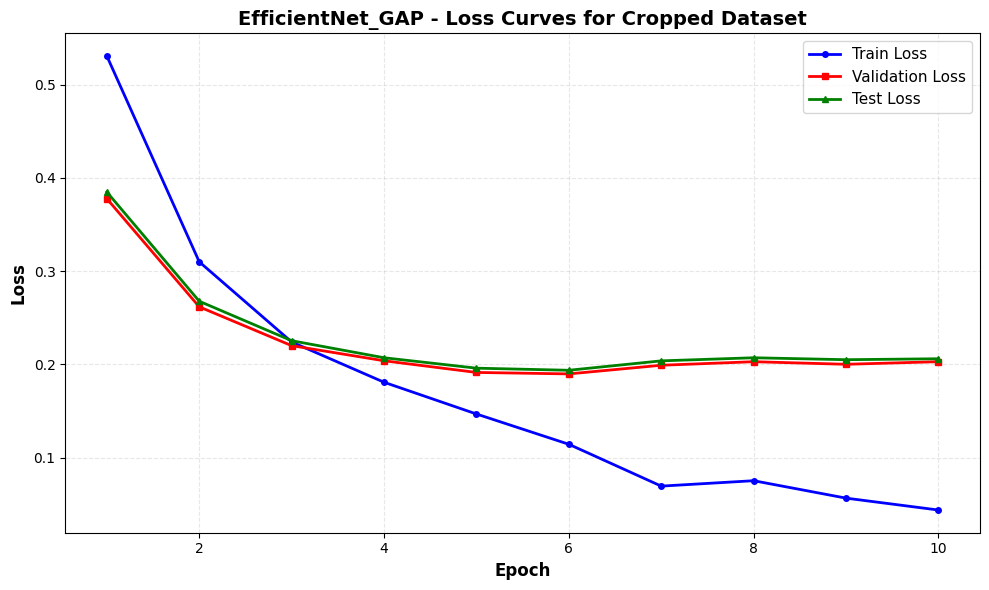

Accuracy curve saved: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/checkpoints_cropped/EfficientNet_GAP_accuracy_curve_Cropped_data.png


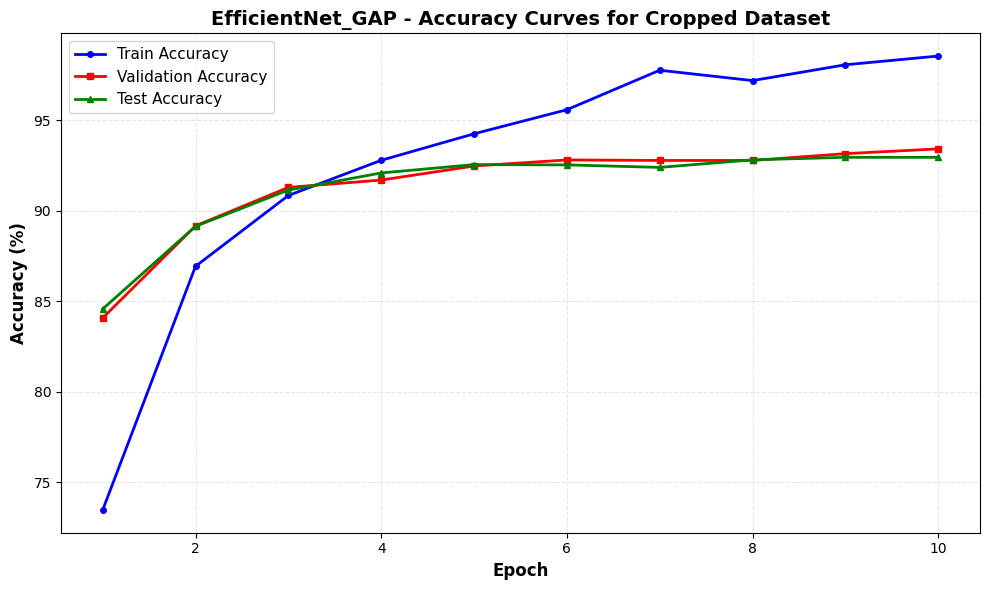


EfficientNet_GAP - Final Results:
Train - Loss: 0.0440, Acc: 98.54%
Val   - Loss: 0.2030, Acc: 93.41%
Test  - Loss: 0.2061, Acc: 92.95%

Loss curve saved: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/checkpoints_cropped/EfficientNet_Flatten_loss_curve_Cropped_data.png


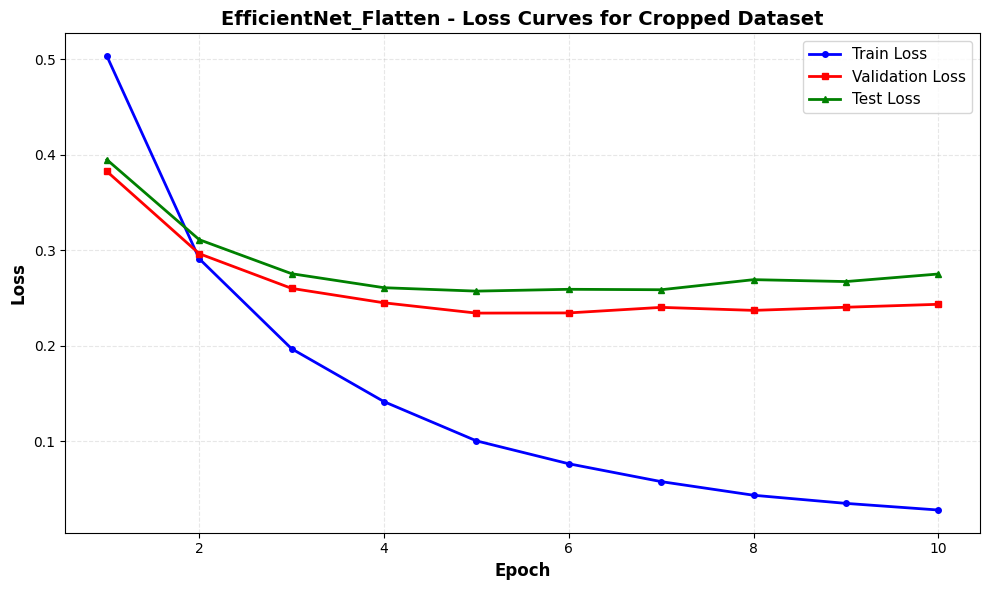

Accuracy curve saved: /mnt/c/Users/prana/Desktop/DL_project/data/cropped/checkpoints_cropped/EfficientNet_Flatten_accuracy_curve_Cropped_data.png


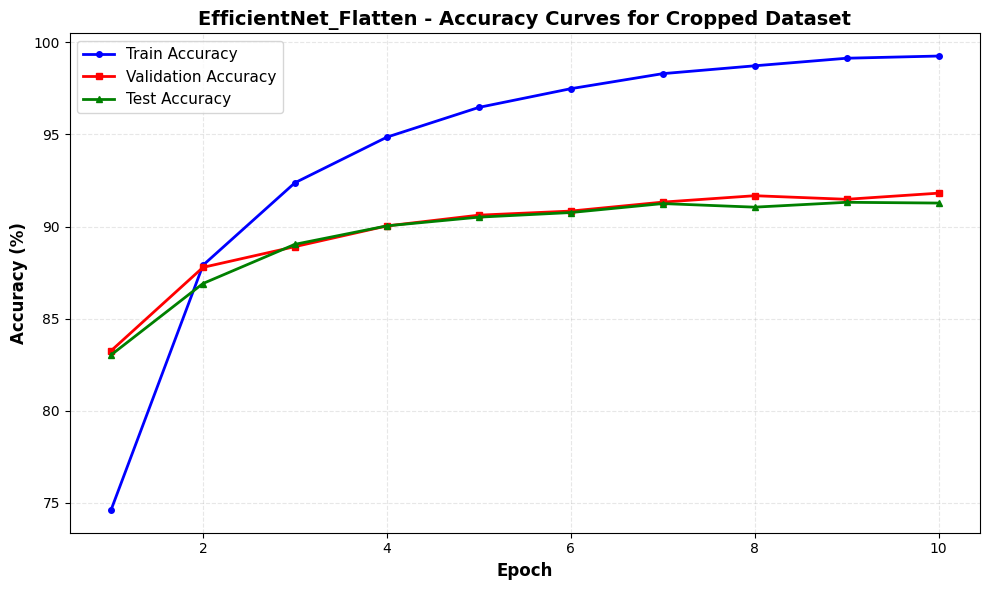


EfficientNet_Flatten - Final Results:
Train - Loss: 0.0283, Acc: 99.26%
Val   - Loss: 0.2436, Acc: 91.81%
Test  - Loss: 0.2753, Acc: 91.28%



In [10]:

plot_curves(history_gap, "EfficientNet_GAP", save_dir=CHECKPOINT_DIR)
plot_curves(history_flatten, "EfficientNet_Flatten", save_dir=CHECKPOINT_DIR)
